**The Start Of It All...**

# Libraries

In [1]:
#Change the width of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Standard Libraries
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import random
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
#User counter to check frequencies (https://pymotw.com/2/collections/counter.html)
from  collections import Counter

In [3]:
#Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pandas.plotting import scatter_matrix
import seaborn as sns
# Pretty display for notebooks
%matplotlib inline
# Import supplementary visualizations code visuals.py
import visuals as vs

In [4]:
#Modelling Libraries
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import tree
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Data

In [5]:
sampleMode = 1

In [6]:
if sampleMode == 1:
    file = "sample_model_data_protected_small5k.csv"
else:
    file = "sample_model_data_protected_60k.csv"
# Load Company IP Intent Data (March Sample)
try:
    full_data = pd.read_csv(file)
    print("Company IP Intent dataset has {} samples with {} features each.".format(*full_data.shape))
except:
    print("Dataset could not be loaded!")

print("Do not use excel UTF-8 format for csv, it breaks stuff...")

Company IP Intent dataset has 5099 samples with 46 features each.
Do not use excel UTF-8 format for csv, it breaks stuff...


## Take a random sample for modelling due to size

In [7]:
def getRandomIDXs(n,d):
    N=len(d)
    indices=[]
    for i in range(0, n):
        randomInt = (random.randint(0, N))
        if randomInt not in indices:
            indices.append(randomInt)
    print("Sample indices selected - ", str(len(indices)))
    return indices

def getRandomSample(n,d):
    N=len(d)
    n=round(n*N)
    indices = getRandomIDXs(n,d)
    sample = pd.DataFrame(d.reindex(indices), columns = d.keys()).reset_index(drop = True)
    #sample = pd.DataFrame(d.loc[indices], columns = d.keys()).reset_index(drop = True)
    print(sample.shape)
    return sample

In [8]:
#Take a sample due to the size of the dataset here
data = getRandomSample(1.0,full_data)
#data = full_data
print("Chosen samples of Company Intent customers dataset:",str(len(data)))
data[:3]

Sample indices selected -  3229
(3229, 46)
Chosen samples of Company Intent customers dataset: 3229


acct_id      hq_id   company userDomain        city        region  \
0  1-10NCV05  1-10NCV05  REDACTED   REDACTED  Vaestervik    Kalmar lan   
1  1-10426BT  1-10426BT  REDACTED   REDACTED   Allentown  Pennsylvania   
2  1-10DADIG   1-GHL4HH  REDACTED   REDACTED      Malone      New York   

  countryCode  revenue_mil_usd  total_employees  naic3  ...  \
0          SE         188.7810           3000.0  623.0  ...   
1          US           6.9941             50.0  541.0  ...   
2          US        1812.8530          30000.0  721.0  ...   

   hits_iabCat_IAB_17  hits_iabCat_IAB_18 hits_iabCat_IAB_19  \
0                16.0                 0.0               82.0   
1                 2.0                 4.0               45.0   
2                 4.0                 5.0               44.0   

   hits_iabCat_IAB_20  hits_iabCat_IAB_21  hits_iabCat_IAB_22  \
0                 0.0                 0.0                35.0   
1                 0.0                 2.0                 9.0   
2                 0.0                 0.0                 1.0   

   hits_iabCat_IAB_23  hits_iabCat_IAB_24  hits_iabCat_IAB_25  \
0                 0.0                 0.0                 0.0   
1                 0.0                 1.0                 0.0   
2                 0.0                 3.0                 0.0   

   hits_iabCat_IAB_26  
0                 0.0  
1                 0.0  
2                 5.0  

[3 rows x 46 columns]

In [9]:
data.dtypes

acct_id                object
hq_id                  object
company                object
userDomain             object
city                   object
region                 object
countryCode            object
revenue_mil_usd       float64
total_employees       float64
naic3                 float64
naic6                 float64
isISP                 float64
usageType              object
datesCount            float64
domainsCount          float64
hitsSum               float64
pageViewsSum          float64
uniqueViewsSum        float64
clicks                float64
clickDates            float64
hits_iabCat_IAB_1     float64
hits_iabCat_IAB_2     float64
hits_iabCat_IAB_3     float64
hits_iabCat_IAB_4     float64
hits_iabCat_IAB_5     float64
hits_iabCat_IAB_6     float64
hits_iabCat_IAB_7     float64
hits_iabCat_IAB_8     float64
hits_iabCat_IAB_9     float64
hits_iabCat_IAB_10    float64
hits_iabCat_IAB_11    float64
hits_iabCat_IAB_12    float64
hits_iabCat_IAB_13    float64
hits_iabCa

In [10]:
#Null fill values to prevent NaN issues
def zeroFillColumn(d):
    cols = d.columns
    for col in cols:
        if is_numeric_dtype(d[col]):
            d[col].fillna(0, inplace = True)
        else:
            d[col].fillna("Unknown", inplace = True)
    return d
data = zeroFillColumn(data)

# Data Exploration
In this sections I will attempt to find correlations in my data with summary statistics and visualations to help guide the supervised learning

### Investigate the Reliability of the Columns
This dataset has been derived from a production system which may have too sparse datapoints for  certain metrics OR just too unreliable due to poor matching between disparate datasets

Flag and remove early on for performance reasons mainly

In [11]:
# Display a description of the dataset
t=data.describe()
t.to_csv('summary_statistics.csv')
data.describe()

revenue_mil_usd  total_employees        naic3          naic6  \
count     3.229000e+03      3229.000000  3229.000000    3229.000000   
mean      3.352560e+04      9117.914525   468.347166  468655.573862   
std       3.970458e+05     42580.925328   197.167294  197183.887208   
min       0.000000e+00         0.000000     0.000000       0.000000   
25%       7.566200e+00        60.000000   332.000000  332312.000000   
50%       1.831860e+01        95.000000   484.000000  484121.000000   
75%       7.547742e+01       510.000000   611.000000  611310.000000   
max       5.057748e+06    570000.000000   928.000000  928120.000000   

             isISP   datesCount  domainsCount        hitsSum   pageViewsSum  \
count  3229.000000  3229.000000   3229.000000    3229.000000    3229.000000   
mean      0.002478    11.990709     42.624342     390.220192    1331.291421   
std       0.049721     8.394024    131.456719    3497.179011   13178.931135   
min       0.000000     0.000000      0.000000       0.000000       0.000000   
25%       0.000000     5.000000      5.000000      11.000000      20.000000   
50%       0.000000    11.000000     13.000000      35.000000      83.000000   
75%       0.000000    18.000000     34.000000     114.000000     330.000000   
max       1.000000    31.000000   3680.000000  108392.000000  423079.000000   

       uniqueViewsSum  ...  hits_iabCat_IAB_17  hits_iabCat_IAB_18  \
count     3229.000000  ...         3229.000000         3229.000000   
mean       606.606070  ...            8.375039            6.105915   
std       5334.439119  ...           62.682351           58.100380   
min          0.000000  ...            0.000000            0.000000   
25%         15.000000  ...            0.000000            0.000000   
50%         53.000000  ...            0.000000            0.000000   
75%        189.000000  ...            3.000000            3.000000   
max     153794.000000  ...         2066.000000         2140.000000   

       hits_iabCat_IAB_19  hits_iabCat_IAB_20  hits_iabCat_IAB_21  \
count         3229.000000         3229.000000         3229.000000   
mean            94.045835            1.059151            3.309074   
std            918.717257            8.784028           33.904887   
min              0.000000            0.000000            0.000000   
25%              1.000000            0.000000            0.000000   
50%              6.000000            0.000000            0.000000   
75%             26.000000            0.000000            1.000000   
max          31710.000000          335.000000         1368.000000   

       hits_iabCat_IAB_22  hits_iabCat_IAB_23  hits_iabCat_IAB_24  \
count         3229.000000         3229.000000         3229.000000   
mean            48.445339            0.132858            2.050480   
std            627.382010            1.096068           15.693537   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              6.000000            0.000000            0.000000   
max          31158.000000           32.000000          524.000000   

       hits_iabCat_IAB_25  hits_iabCat_IAB_26  
count         3229.000000         3229.000000  
mean             0.000310            2.628678  
std              0.017598           22.540338  
min              0.000000            0.000000  
25%              0.000000            0.000000  
50%              0.000000            0.000000  
75%              0.000000            0.000000  
max              1.000000          690.000000  

[8 rows x 38 columns]

- Ignore NAICS codes.

- hitsSum/pageViewsSum/uniqueViewsSum/most of the iabCat hits - Massively varying between accounts. Highlighy right skewed, with the std way over the 75th percentile
- Alot of iabCat hits with 0 as the values for everything below the 75th percentile. Likely needs to be removed from the dataset as no significant inferences can be made if only a few companies have hits for the certain categories

In [12]:
#Group columns together for analysis
iabCat_hits_cols = [col for col in data.columns if 'hits_iabCat' in col]
summaryMetricCols = ['datesCount', 'domainsCount', 'hitsSum','pageViewsSum', 'uniqueViewsSum', 'clicks', 'clickDates']
labelCols = ['acct_id','hq_id','company','userDomain','city','region','countryCode','revenue_mil_usd','total_employees']
coninuousCols = iabCat_hits_cols + summaryMetricCols + ['revenue_mil_usd','total_employees']

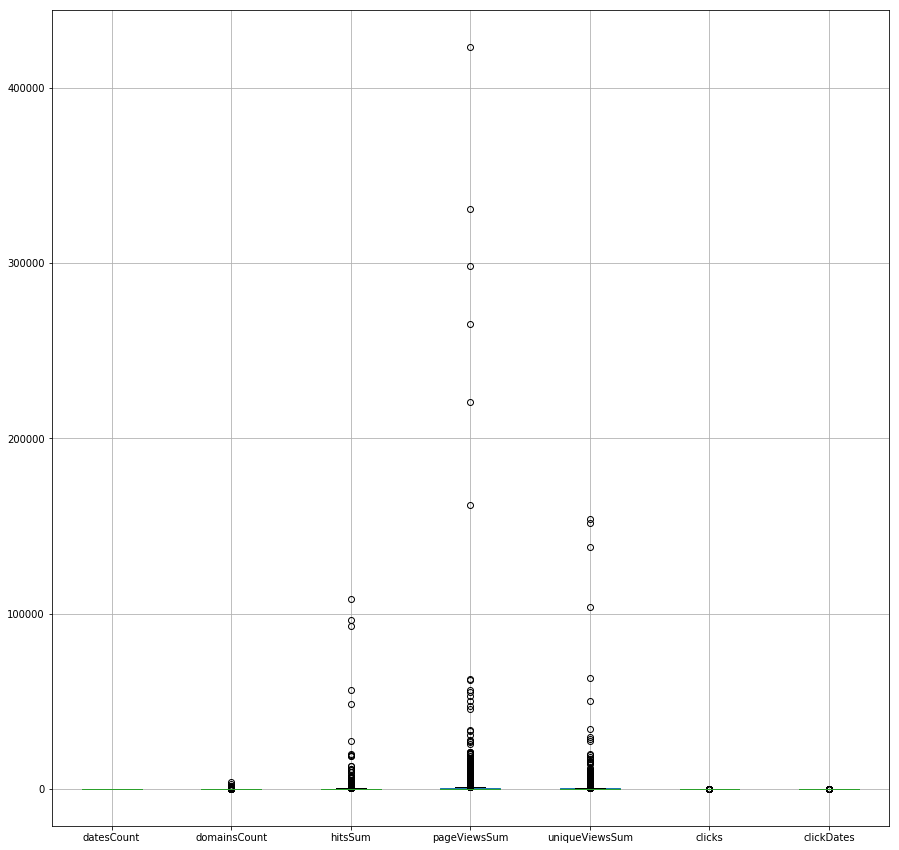

In [13]:
boxplot = data.boxplot(column=summaryMetricCols,figsize=(15,15))

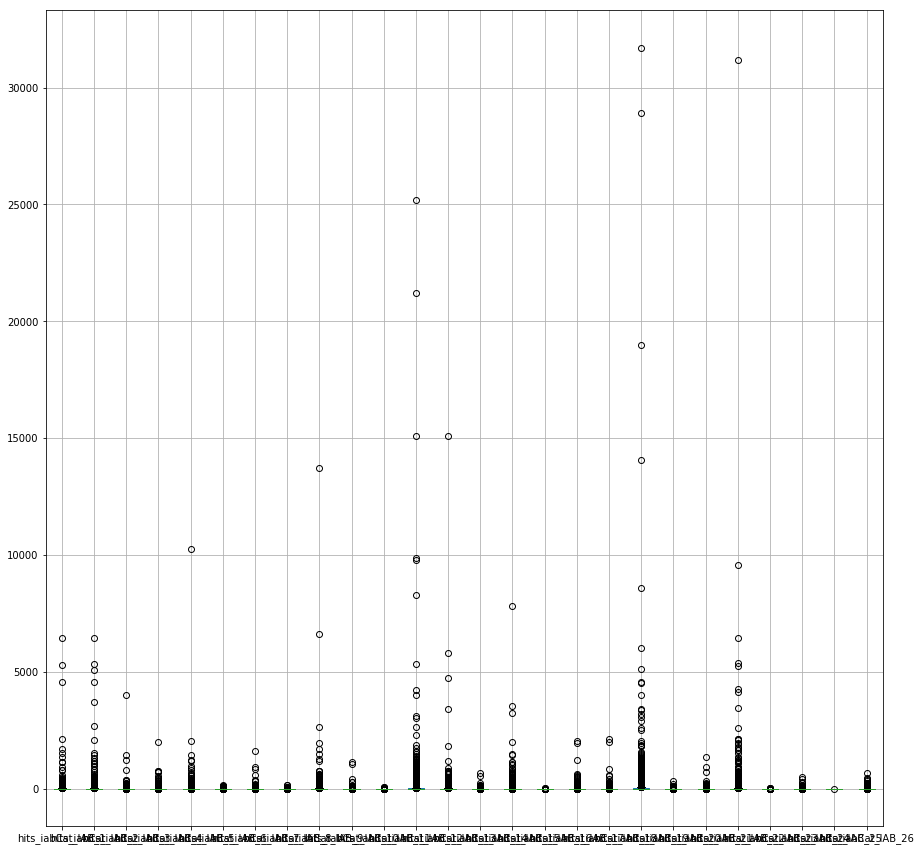

In [14]:
boxplot = data.boxplot(column=iabCat_hits_cols,figsize=(15,15))

### Remove outlier columns early on

In [15]:
#Get Outliers IDXs per feature column
def getOutLierIDXs(d):
    #Intialise counters
    outliers = []
    featureDict = {}
    typeDict = data.columns.to_series().groupby(data.dtypes).groups
    # For each feature find the data points with extreme high or low values
    for feature in d.keys():
        #Break early if not a number value
        if is_numeric_dtype(d[feature]):
            #Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(d[feature],25)
            #Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(d[feature],75)
            #Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
            step = (Q3 - Q1)*1.5
            #Outlier if value step below lower quartile OR step above upper quartile
            featureOutliers = d[(d[feature] <= Q1 - step) | (d[feature] >= Q3 + step)]
            outlierIDXs = featureOutliers.index.tolist()
            featureDict[feature] = len(featureOutliers)
            print("Number of outliers detected for feature - " + str(feature) + " = " +str(len(featureOutliers)))
            #Add to global list of outliersIDXs
            outliers.extend(outlierIDXs)
    return (outliers,featureDict)

In [16]:
#Remove any columns where all values are classed as outulier, a good few iabCat columns
res = getOutLierIDXs(data)
outliers = res[0]
featureDict = res[1]

#Clean dataset
datac = data.copy()
badBoys = []
for feature in featureDict.keys():
    if (featureDict[feature]) == len(datac):
        badBoys.append(feature)
        print(str(feature) + "- Feature added to blacklist")
#Drop Bad columns
for feature in badBoys:
    datac.drop([feature], axis = 1, inplace = True)

Number of outliers detected for feature - revenue_mil_usd = 579
Number of outliers detected for feature - total_employees = 563
Number of outliers detected for feature - naic3 = 0
Number of outliers detected for feature - naic6 = 0
Number of outliers detected for feature - isISP = 3229
Number of outliers detected for feature - datesCount = 0
Number of outliers detected for feature - domainsCount = 356
Number of outliers detected for feature - hitsSum = 427
Number of outliers detected for feature - pageViewsSum = 450
Number of outliers detected for feature - uniqueViewsSum = 403
Number of outliers detected for feature - clicks = 3229
Number of outliers detected for feature - clickDates = 3229
Number of outliers detected for feature - hits_iabCat_IAB_1 = 428
Number of outliers detected for feature - hits_iabCat_IAB_2 = 464
Number of outliers detected for feature - hits_iabCat_IAB_3 = 483
Number of outliers detected for feature - hits_iabCat_IAB_4 = 494
Number of outliers detected for fea

In [17]:
#Remove outlier function
def getMultiClassOutliers(d):
    #Get outlier indexes per column
    res = getOutLierIDXs(d)
    outliers = res[0]
    featureDict = res[1]
    #Capture multi-feature outliers
    multiOutliers=[]
    countsDict = dict(Counter(outliers))
    for idx in list(countsDict.keys()):
        if countsDict[idx] > 1:
            multiOutliers.append(idx)
            print('Multi-Feature outlier found at index = ' + str(idx))
    print('Total multi-Feature outliers found = ' + str(len(multiOutliers)) + ' out of sample of ' + str(len(d)))
    return multiOutliers

In [18]:
#Re-run outlier detection and remove multi-feature outliers
outliersN = getMultiClassOutliers(datac)

Number of outliers detected for feature - revenue_mil_usd = 579
Number of outliers detected for feature - total_employees = 563
Number of outliers detected for feature - naic3 = 0
Number of outliers detected for feature - naic6 = 0
Number of outliers detected for feature - datesCount = 0
Number of outliers detected for feature - domainsCount = 356
Number of outliers detected for feature - hitsSum = 427
Number of outliers detected for feature - pageViewsSum = 450
Number of outliers detected for feature - uniqueViewsSum = 403
Number of outliers detected for feature - hits_iabCat_IAB_1 = 428
Number of outliers detected for feature - hits_iabCat_IAB_2 = 464
Number of outliers detected for feature - hits_iabCat_IAB_3 = 483
Number of outliers detected for feature - hits_iabCat_IAB_4 = 494
Number of outliers detected for feature - hits_iabCat_IAB_5 = 572
Number of outliers detected for feature - hits_iabCat_IAB_7 = 520
Number of outliers detected for feature - hits_iabCat_IAB_9 = 435
Number o

Multi-Feature outlier found at index = 2422
Multi-Feature outlier found at index = 2424
Multi-Feature outlier found at index = 2432
Multi-Feature outlier found at index = 2486
Multi-Feature outlier found at index = 2525
Multi-Feature outlier found at index = 2552
Multi-Feature outlier found at index = 2563
Multi-Feature outlier found at index = 2656
Multi-Feature outlier found at index = 2734
Multi-Feature outlier found at index = 2742
Multi-Feature outlier found at index = 2910
Multi-Feature outlier found at index = 2918
Multi-Feature outlier found at index = 2951
Multi-Feature outlier found at index = 3045
Multi-Feature outlier found at index = 3046
Multi-Feature outlier found at index = 3049
Multi-Feature outlier found at index = 3159
Multi-Feature outlier found at index = 3
Multi-Feature outlier found at index = 6
Multi-Feature outlier found at index = 29
Multi-Feature outlier found at index = 42
Multi-Feature outlier found at index = 69
Multi-Feature outlier found at index = 97
Mu

Multi-Feature outlier found at index = 2480
Multi-Feature outlier found at index = 2513
Multi-Feature outlier found at index = 2561
Multi-Feature outlier found at index = 2791
Multi-Feature outlier found at index = 2853
Multi-Feature outlier found at index = 2868
Multi-Feature outlier found at index = 2885
Multi-Feature outlier found at index = 2960
Multi-Feature outlier found at index = 3104
Multi-Feature outlier found at index = 3117
Multi-Feature outlier found at index = 810
Multi-Feature outlier found at index = 2975
Multi-Feature outlier found at index = 260
Multi-Feature outlier found at index = 368
Multi-Feature outlier found at index = 588
Multi-Feature outlier found at index = 981
Multi-Feature outlier found at index = 1770
Multi-Feature outlier found at index = 2434
Multi-Feature outlier found at index = 2754
Multi-Feature outlier found at index = 64
Multi-Feature outlier found at index = 96
Multi-Feature outlier found at index = 516
Multi-Feature outlier found at index = 572

In [19]:
#Remove outliers
print('Total outliers detected = '+str(len(outliersN)) + ' out of a total sample of ' + str(len(datac)))
good_data = datac.drop(datac.index[outliersN]).reset_index(drop = True)
print('Muli-class outliers removed, and noisey columns removed. Remaining rows = {}, remaining columns = {}'.format(*good_data.shape))

Total outliers detected = 1330 out of a total sample of 3229
Muli-class outliers removed, and noisey columns removed. Remaining rows = 1899, remaining columns = 33


In [20]:
#Reset Metric Columns after blacklisting
iabCat_hits_cols = [col for col in good_data.columns if 'hits_iabCat' in col]
summary_metric_cols = ['datesCount', 'domainsCount', 'hitsSum','pageViewsSum', 'uniqueViewsSum', 'clicks', 'clickDates']
label_cols = ['acct_id','hq_id','company','userDomain','city','region','countryCode','revenue_mil_usd','total_employees']
continuous_cols = iabCat_hits_cols + ['revenue_mil_usd','total_employees']

#Ensure only columns still remaining
current_cols = good_data.columns
iabCat_hits_cols = sorted(list(set(iabCat_hits_cols) & set(current_cols)))
summary_metric_cols = list(set(summary_metric_cols) & set(current_cols))
label_cols = list(set(label_cols) & set(current_cols))
continuous_cols = sorted(list(set(continuous_cols) & set(current_cols)))

###  Random Sample Analysis
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail.

In [21]:
#Generate random samples to investigate quickly and visually
portion=0.005
samples = getRandomSample(portion,good_data)
sample_size=len(samples)
print("Chosen samples of Company Intent customers dataset:")
display(samples)

#Visualise Sample data
samples_for_plot = samples.copy()
samples_for_plot = samples_for_plot[summary_metric_cols]
#Add median plot as well
columnsN = len(samples_for_plot.columns)
samples_for_plot.loc[sample_size + 1] = good_data.median()
#Create lables
labels=[]
for i in range(0,sample_size):
    name = 'Sample_'+str(i)
    labels.append(name)    

labels.append('Median') 

Sample indices selected -  9
(9, 33)
Chosen samples of Company Intent customers dataset:


acct_id      hq_id   company userDomain           city       region  \
0  1-1008UAE   1-YIDRR5  REDACTED   REDACTED        Anaheim   California   
1  1-10LADRK  1-QJO-705  REDACTED   REDACTED      Tranbjerg  Midtjylland   
2  1-10Q1AWN  1-10Q1AWN  REDACTED   REDACTED         Lynden   Washington   
3  1-10QGCTF  1-10QGCTF  REDACTED   REDACTED    Saint Clair     Michigan   
4  1-105SDKO  1-105SDKO  REDACTED   REDACTED       Portland       Oregon   
5  1-10FCA5X  1-10FCA5X  REDACTED   REDACTED          Pharr        Texas   
6  1-10JENYE   1-6HE4W9  REDACTED   REDACTED    Saint Louis     Missouri   
7  1-1055N9T  1-1055N9T  REDACTED   REDACTED  Mountain View   California   
8  1-10CEWY4   1-T4KG99  REDACTED   REDACTED        Newbury      England   

  countryCode  revenue_mil_usd  total_employees  naic3  ...  \
0          US         10.10130             90.0  484.0  ...   
1          DK         67.79649             35.0  813.0  ...   
2          US         13.73930             49.0  453.0  ...   
3          US          9.42010             73.0  484.0  ...   
4          US         15.52020             70.0  336.0  ...   
5          US         10.35140             62.0  442.0  ...   
6          US          7.31530            175.0  813.0  ...   
7          US         12.27210             78.0  541.0  ...   
8          GB         15.24755             90.0  323.0  ...   

   hits_iabCat_IAB_9 hits_iabCat_IAB_10  hits_iabCat_IAB_12  \
0                2.0                1.0                 0.0   
1                1.0                0.0                 8.0   
2                0.0                0.0                 0.0   
3                1.0                0.0                 8.0   
4                0.0                0.0                 2.0   
5                2.0                0.0                 2.0   
6                2.0                3.0                41.0   
7                3.0                1.0                 4.0   
8                0.0                0.0                 7.0   

   hits_iabCat_IAB_13  hits_iabCat_IAB_15  hits_iabCat_IAB_17  \
0                 1.0                 2.0                 1.0   
1                 0.0                 1.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 3.0   
4                 2.0                 0.0                 0.0   
5                14.0                 0.0                 4.0   
6                 0.0                 1.0                 0.0   
7                 1.0                 0.0                 0.0   
8                 1.0                 0.0                 0.0   

   hits_iabCat_IAB_18  hits_iabCat_IAB_19  hits_iabCat_IAB_21  \
0                 2.0                 7.0                 1.0   
1                 0.0                22.0                 0.0   
2                 0.0                 0.0                 1.0   
3                 2.0                 3.0                 0.0   
4                 0.0                 4.0                 0.0   
5                 0.0                31.0                 0.0   
6                 5.0                 5.0                 0.0   
7                 1.0                 7.0                 0.0   
8                 9.0                 1.0                 0.0   

   hits_iabCat_IAB_22  
0                 0.0  
1                 2.0  
2                 0.0  
3                 5.0  
4                 0.0  
5                 3.0  
6                 0.0  
7                 7.0  
8                 0.0  

[9 rows x 33 columns]

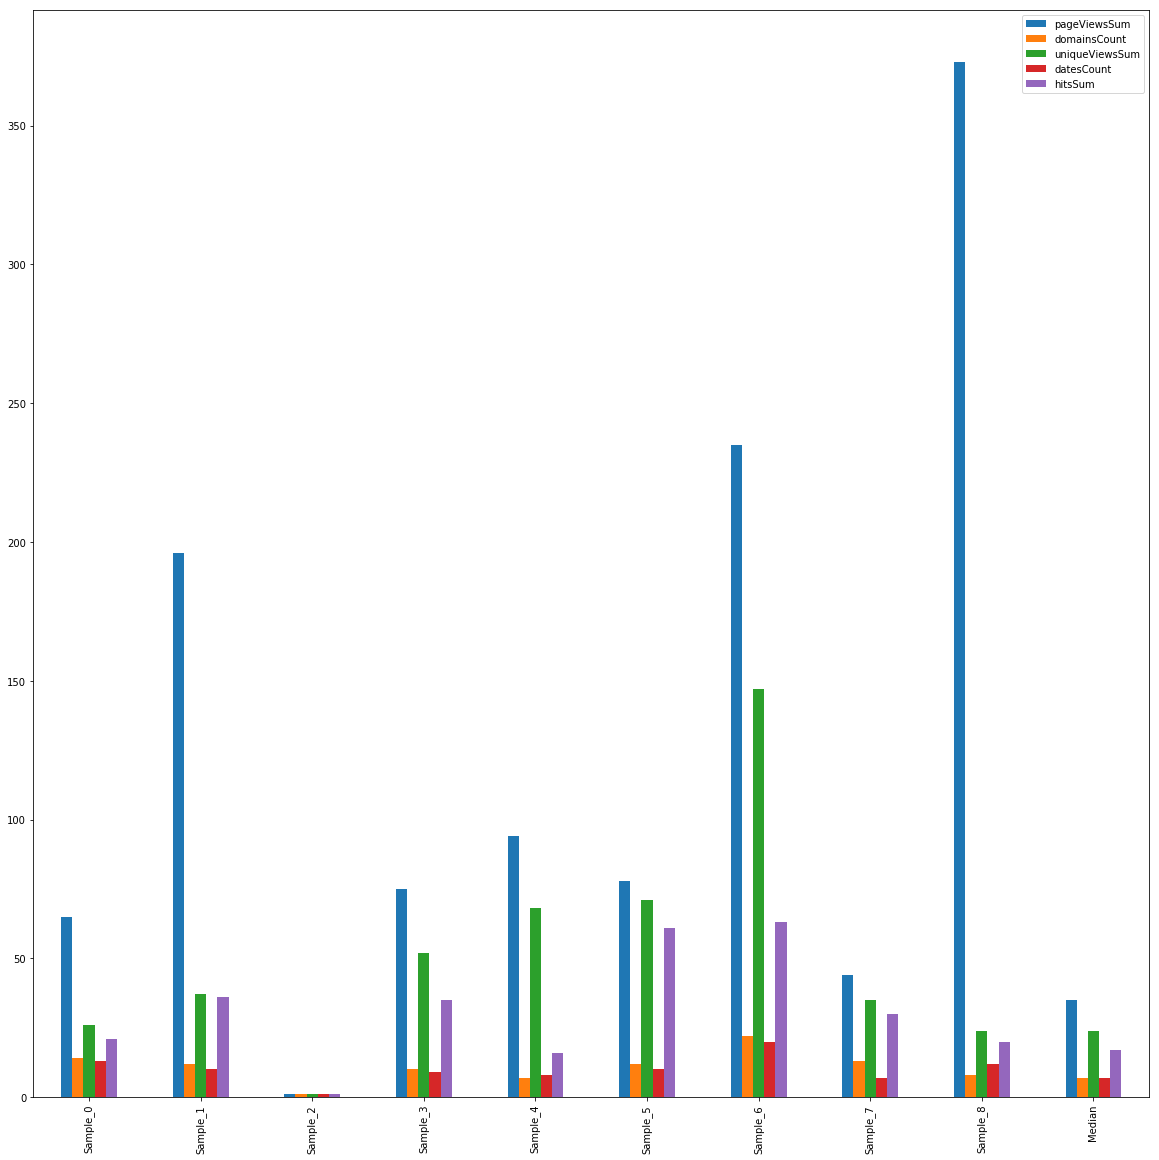

<Figure size 432x288 with 0 Axes>

In [22]:
#Plot graph
samples_for_plot.plot(kind='bar',figsize=(20,20))
plt.xticks(range(sample_size+1),labels)
plt.figure()
plt.show()

- Can see that some accounts have significantly higher activity than others

In [23]:
#For a better comparison, we will look at the heat map of the data
summary_data = samples[summary_metric_cols]
percentiles_summary_data = 100*summary_data.rank(pct=True)

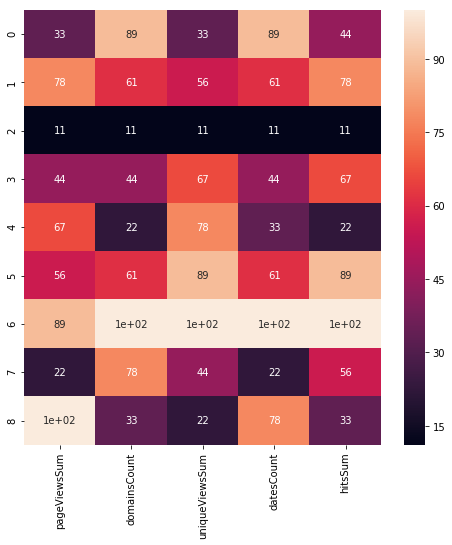

In [24]:
plt.figure(figsize=(8,8))
sns.heatmap(percentiles_summary_data, annot=True)

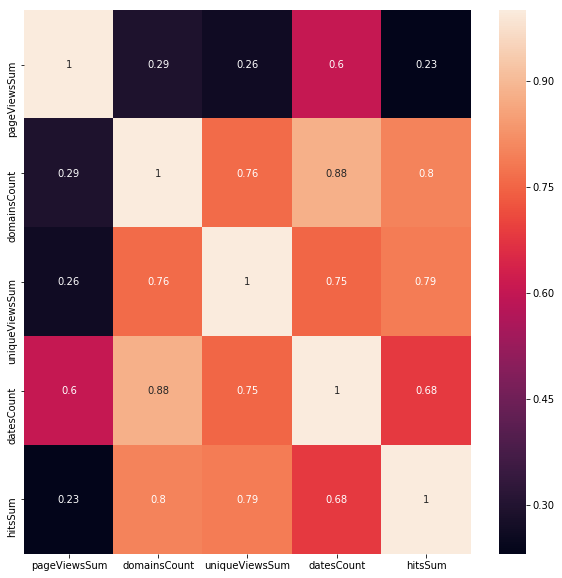

In [25]:
#Correlation heatmap!
plt.figure(figsize=(10,10))
sns.heatmap(summary_data.corr(),annot=True)

In [26]:
#Look at breakdown by IAB Cat
continuous_data = good_data[continuous_cols]
#Expensive operation so run the calculations first and graph seperately
correlations = continuous_data.corr()

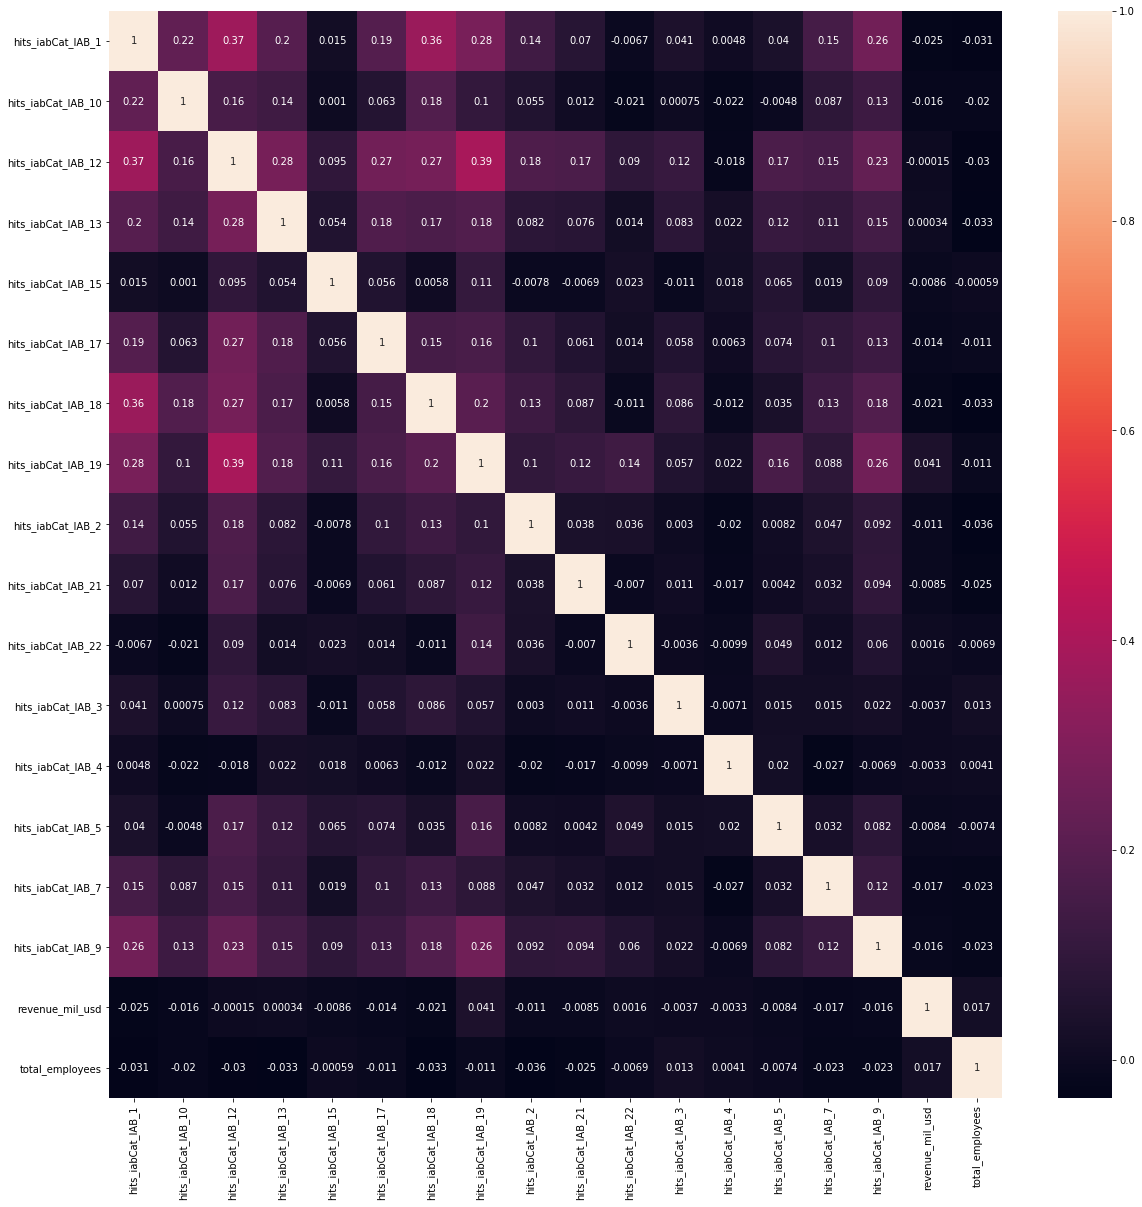

In [27]:
plt.figure(figsize=(20, 20))
sns.heatmap(correlations,annot=True)

- Potential data quality issue with revenue_mil_usd and total_employees. These should be correlated right?

### Predictive Power of Features
Quick analysis to see if there are any clear inference a supervised learning could generate from the data

In [28]:
#Prepare target value (category 19 is what we specialise in selling so lates try this one)
target = 'hits_iabCat_IAB_19'
#Returns a series for all the target values (same as keying a dict in kdb!)
target_data = continuous_data[target]
#Ravel series data as single column target
target_data = target_data.ravel()

#Drop target so we can use a feature
continuous_data.drop([target], axis = 1, inplace = True)
print("Wholesale customers dataset created to predict " + target +  " has {} samples with {} features each.".format(*continuous_data.shape))

Wholesale customers dataset created to predict hits_iabCat_IAB_19 has 1899 samples with 17 features each.


C:\Users\cbath\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
#Split the data into training and testing sets(0.25)
X_train, X_test, y_train, y_test = train_test_split(continuous_data, target_data, test_size=0.25, random_state=10)

#Create a decision tree regressor and fit it to the training set
regressor = tree.DecisionTreeRegressor(max_depth=25)
regressor = regressor.fit(X_train,y_train)
print('DecisionTreeRegressor fit to training data')

# TODO: Report the score of the prediction using the testing set
testPredictions = regressor.predict(X_test)
testPredictions = testPredictions
print('DecisionTreeRegressor test predictions ran')

#Score must be relevant to a regressor(r2 score used)
score = regressor.score(X_test, y_test)
print(score)

DecisionTreeRegressor fit to training data
DecisionTreeRegressor test predictions ran
-0.37974863208758736


- Very poor predictions soley based on IAB Activity trying to predict hits_iabCat_IAB_19.

# Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

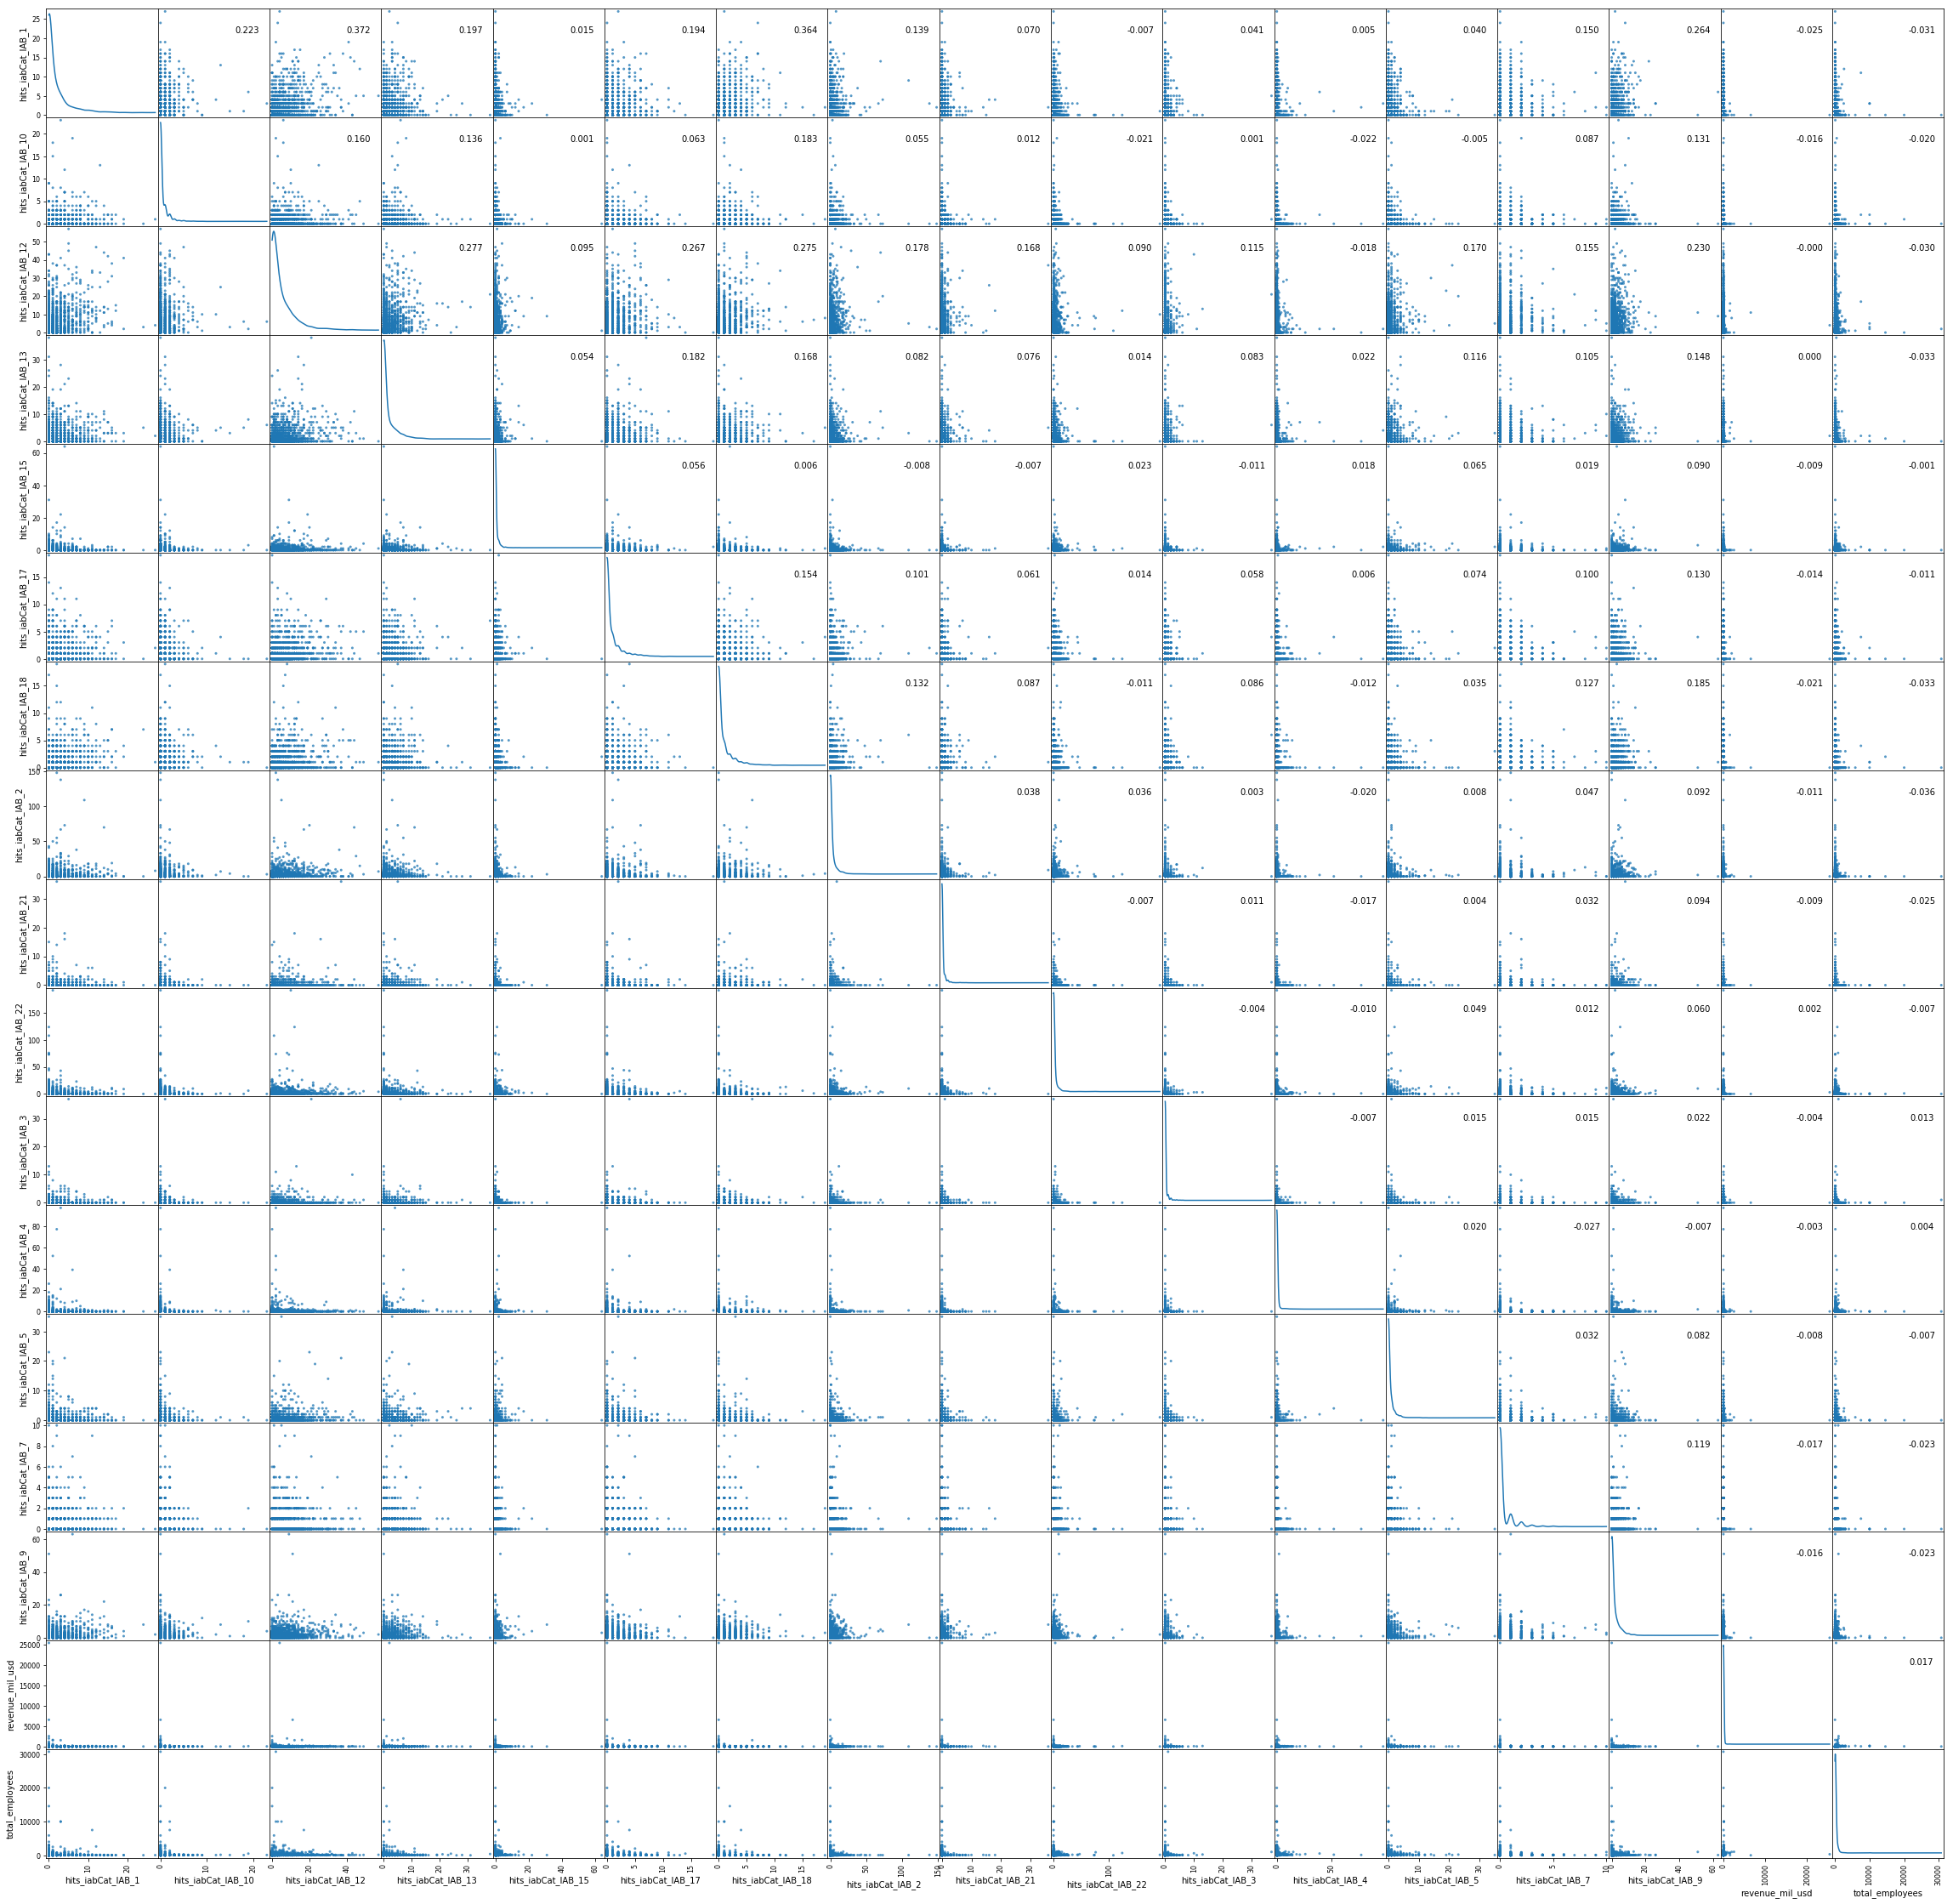

In [30]:
# Produce a scatter matrix for each pair of features in the data
axes = scatter_matrix(continuous_data, alpha=0.75, figsize = (40,40), diagonal = 'kde')
corr = continuous_data.corr().values
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

- All the continuious columns are skewed to the right. Going to need some data conversions here

# Benchmark Model
I will create here a basic model that will be used to generate a benchmark for further, parameter and data optimised, models to compare against in order to gauge how much improvment each iteration of the model is generating.

## Benchmark Dimensionality Reduction to Visualise

In [31]:
#Limit to only continuous features
bench_data = good_data[continuous_cols]
bench_samples = samples[continuous_cols]

array(['hits_iabCat_IAB_1', 'hits_iabCat_IAB_10', 'hits_iabCat_IAB_12',
       'hits_iabCat_IAB_13', 'hits_iabCat_IAB_15', 'hits_iabCat_IAB_17',
       'hits_iabCat_IAB_18', 'hits_iabCat_IAB_19', 'hits_iabCat_IAB_2',
       'hits_iabCat_IAB_21', 'hits_iabCat_IAB_22', 'hits_iabCat_IAB_3',
       'hits_iabCat_IAB_4', 'hits_iabCat_IAB_5', 'hits_iabCat_IAB_7',
       'hits_iabCat_IAB_9', 'revenue_mil_usd', 'total_employees'],
      dtype=object)

Total dataset components = 18


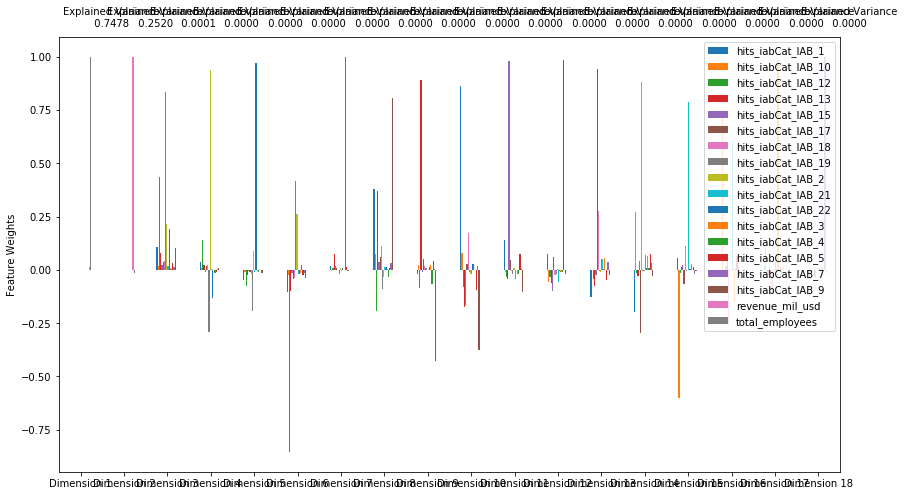

In [32]:
#Apply PCA by fitting the good data with the same number of dimensions as features
components = np.unique(bench_data.keys())
nc = componentsN = len(components)
display(components)
pca = PCA(n_components=componentsN).fit(bench_data)
print('Total dataset components = ' + str(componentsN))

#Transform the good data using the PCA fit above
reduced_data = pca.transform(bench_data)

#Transform samples using the PCA fit above
pca_samples = pca.transform(bench_samples)

# Generate PCA results plot
pca_results = vs.pca_results(bench_data, pca)

#Transform samples using the PCA fit above
pca_samples = pca.transform(bench_samples)

#Create a DataFrame for the reduced data
column_names = []
for i in range(1,nc+1):
    name = 'Dimension '+str(i)
    column_names.append(name)
reduced_data = pd.DataFrame(reduced_data, columns = column_names)

In [33]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#Apply your clustering algorithm of choice to the reduced data 
clusterer =  KMeans(n_clusters=3,random_state=1).fit(bench_data)
#Predict the cluster for each data point
preds = clusterer.predict(bench_data)
#Find the cluster centers (not applicable to DB scan)
centers = clusterer.cluster_centers_ 
#display(centers)

#Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(bench_data, preds)
print(score)

0.9790863624154715


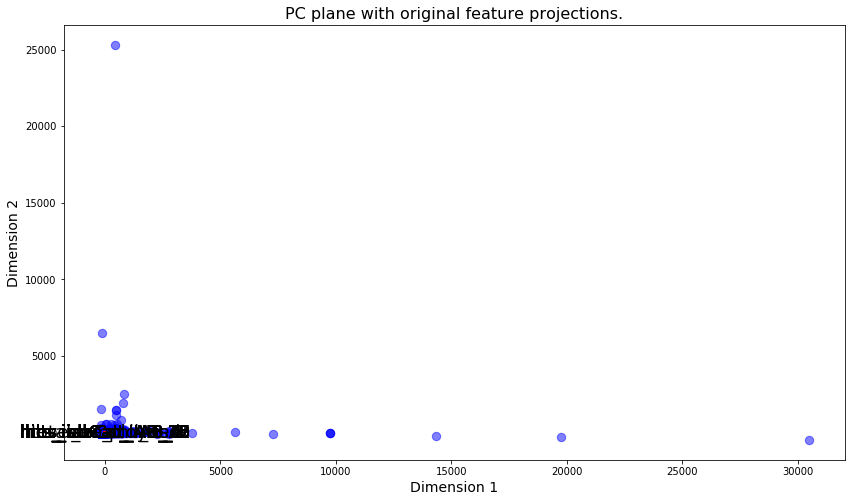

In [34]:
# Create a biplot
vs.biplot(bench_data, reduced_data, pca)

## Creating Bench Mark Clusters

In [35]:
#Example https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
clustersN=3
#Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=clustersN,random_state=1).fit(reduced_data)
#Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
#Find the cluster centers (not applicable to DB scan)
centers = clusterer.cluster_centers_ 
#display(centers)

#Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print(score)

0.9790863624154716


Appears to be a very good scores here. But looking at the visualisation this is false positive as due to the distribution of data it is simply placing the vast majority of clusters into one cluster that is far away from the other 2 clusters

### Cluster Visualization


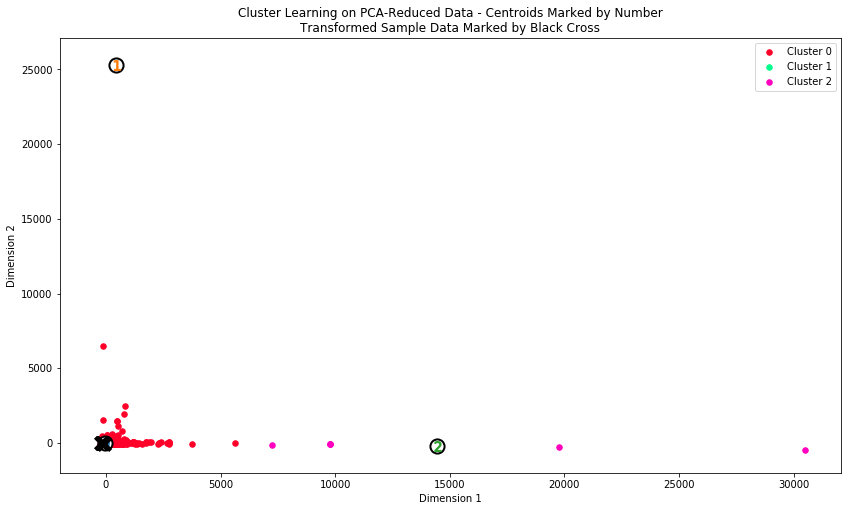

In [36]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

## Feature Scaling

In [37]:
#Limit to only continuous features
good_data = good_data[continuous_cols]
samples = samples[continuous_cols]
#Scale the data using the natural logarithm
log_data = good_data.apply(lambda x: np.log(x+1))
log_samples = samples.apply(lambda x: np.log(x+1))

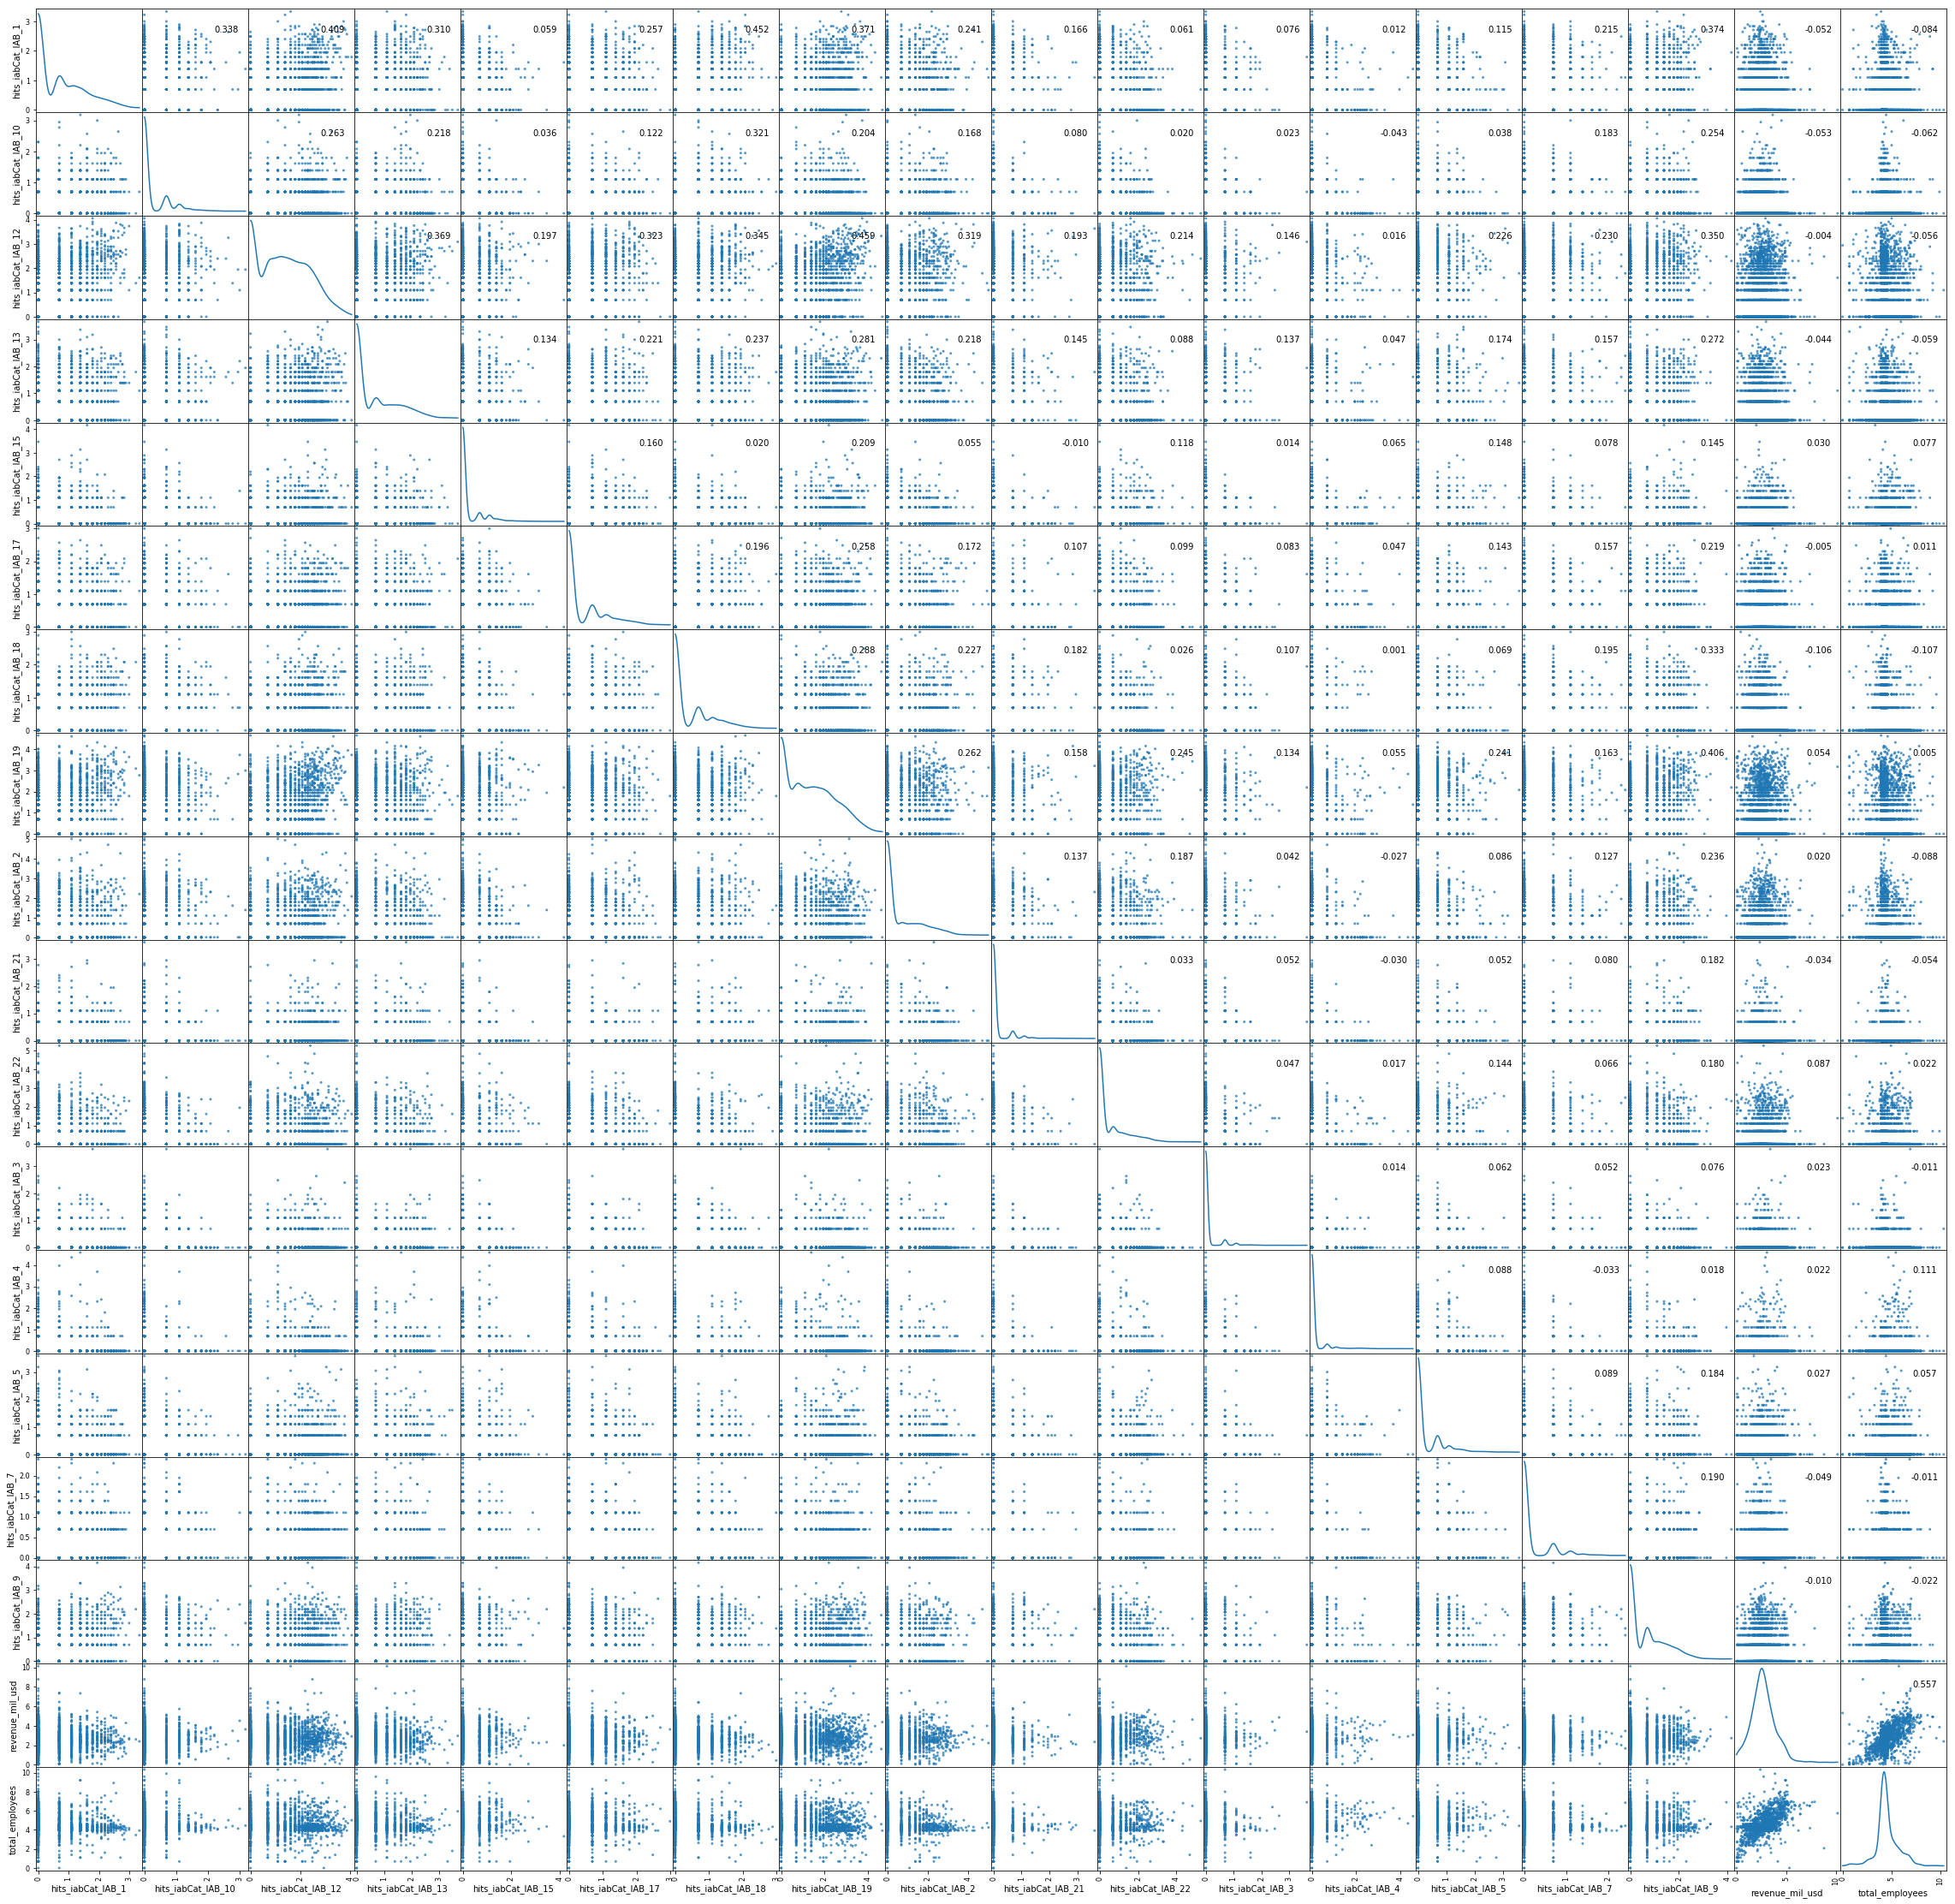

In [38]:
# Produce a scatter matrix for each pair of newly-transformed features
axes = scatter_matrix(log_data, alpha=0.75, figsize = (40,40), diagonal = 'kde')
corr = log_data.corr().values
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

In [39]:
#Not quite normarmally distrubuted for a lot of columns, lets try the boxco transformation
#Another option in that case is the BoxCox transformation. WE CAN'T AS WE HAVE 0 VALUES PRESENT
#boxcox_data = reduced_data.apply(lambda x: boxcox(x)[0])
#pd.scatter_matrix(boxcox_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');

### Dimensionality Reduction using PCA

array(['hits_iabCat_IAB_1', 'hits_iabCat_IAB_10', 'hits_iabCat_IAB_12',
       'hits_iabCat_IAB_13', 'hits_iabCat_IAB_15', 'hits_iabCat_IAB_17',
       'hits_iabCat_IAB_18', 'hits_iabCat_IAB_19', 'hits_iabCat_IAB_2',
       'hits_iabCat_IAB_21', 'hits_iabCat_IAB_22', 'hits_iabCat_IAB_3',
       'hits_iabCat_IAB_4', 'hits_iabCat_IAB_5', 'hits_iabCat_IAB_7',
       'hits_iabCat_IAB_9', 'revenue_mil_usd', 'total_employees'],
      dtype=object)

Total dataset components = 18


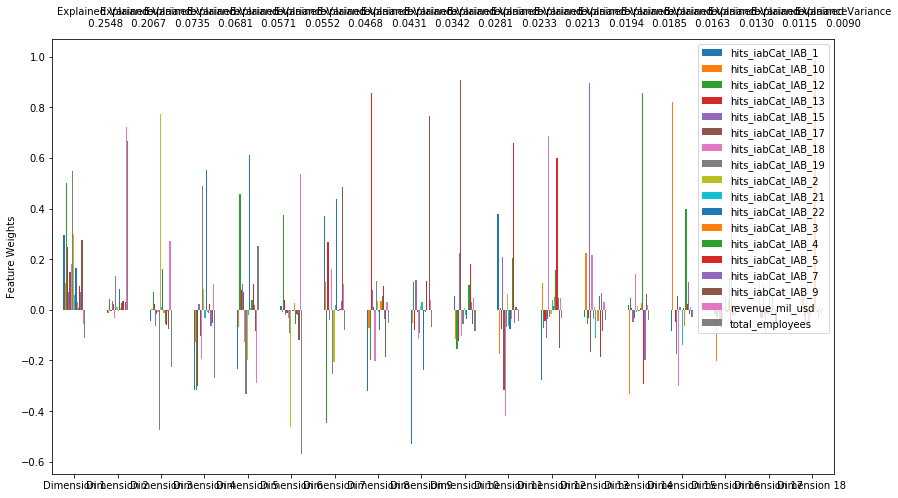

In [40]:
#Apply PCA by fitting the good data with the same number of dimensions as features
components = np.unique(log_data.keys())
componentsN = len(components)
display(components)
pca = PCA(n_components=componentsN).fit(log_data)
print('Total dataset components = ' + str(componentsN))

#Transform the good data using the PCA fit above
reduced_data = pca.transform(log_data)

#Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(log_data, pca)

In [41]:
print(pca_results['Explained Variance'].cumsum())

Dimension 1     0.2548
Dimension 2     0.4615
Dimension 3     0.5350
Dimension 4     0.6031
Dimension 5     0.6602
Dimension 6     0.7154
Dimension 7     0.7622
Dimension 8     0.8053
Dimension 9     0.8395
Dimension 10    0.8676
Dimension 11    0.8909
Dimension 12    0.9122
Dimension 13    0.9316
Dimension 14    0.9501
Dimension 15    0.9664
Dimension 16    0.9794
Dimension 17    0.9909
Dimension 18    0.9999
Name: Explained Variance, dtype: float64


In [42]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, sample_size), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0     0.373305    -0.167590    -0.654924     0.252178    -1.129142   
1     1.304283     0.879927    -0.042095     1.953268    -0.309865   
2    -2.120556    -0.697950     0.234817     0.186270    -0.373380   
3     1.327333    -0.275121    -0.374928    -0.164797     0.777257   
4     0.326883    -0.139276    -0.042961    -0.366488    -0.878076   
5     2.414801    -0.043133    -0.078185     1.107894    -0.289075   
6     1.823110     0.096358    -1.003466    -1.498565     0.572658   
7     1.210261     0.110829    -0.678787     1.047251     0.926762   
8     0.107254    -0.135549    -0.118391    -1.264921    -0.015412   

   Dimension 6  Dimension 7  Dimension 8  Dimension 9  Dimension 10  \
0    -0.824513     0.561782     0.318258     0.306335      0.548252   
1     1.469665    -0.839837    -0.035602     0.537913     -0.173054   
2     0.360459     0.122430     0.047420     0.078046      0.030375   
3     0.541452     0.953695    -1.566035    -1.263244      0.747047   
4     0.240980     0.117806     0.296860    -1.171493     -0.263073   
5    -0.608097     0.483539     2.052102    -0.225982      0.701010   
6     0.383197    -0.720374    -1.629161     0.102991     -0.954128   
7     0.254405     1.028610    -0.134819     0.245218     -0.400337   
8     0.760699    -0.068676    -0.538159    -0.718182     -0.633014   

   Dimension 11  Dimension 12  Dimension 13  Dimension 14  Dimension 15  \
0     -0.076049      0.641933      0.833478     -0.352668     -0.124509   
1      0.374615      0.082864      0.284018     -0.094298     -0.070482   
2     -0.057246      0.038257     -0.062918     -0.040858     -0.115641   
3     -0.169814     -0.294464     -0.308705      0.242600     -0.486330   
4      0.617865     -0.754383     -0.200157      0.044210     -0.236431   
5     -0.700721     -0.727103     -0.639553      0.051099     -0.095169   
6     -0.474285      0.374446      0.859501     -0.088090      0.293430   
7      0.672509      1.042770     -0.360854     -0.542020      0.288949   
8     -0.671142      1.073506      0.297788      0.382264     -0.847217   

   Dimension 16  Dimension 17  Dimension 18  
0     -0.331635      0.618897     -0.055672  
1     -0.085789     -0.081138     -0.133973  
2      0.040235      0.673554     -0.022855  
3     -0.286782     -0.251512     -0.136711  
4     -0.068766     -0.115102     -0.078526  
5     -0.204071     -0.284754     -0.228468  
6     -0.572480     -0.153949     -0.087966  
7     -0.382263     -0.141532     -0.128719  
8     -0.196462     -0.324890     -0.233915

In [43]:
#Apply PCA by fitting the good data with only 11 dimensions (based on ~90% of variance explained by 11 components above)
nc = 10
pca = PCA(n_components=nc).fit(log_data)

#Transform the good data using the PCA fit above
reduced_data = pca.transform(log_data)

#Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

#Create a DataFrame for the reduced data
column_names = []
for i in range(1,nc+1):
    name = 'Dimension '+str(i)
    column_names.append(name)
reduced_data = pd.DataFrame(reduced_data, columns = column_names)

In [44]:
# Display sample log-data after applying PCA transformation in two dimensions
#display(reduced_data)

### Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components. In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

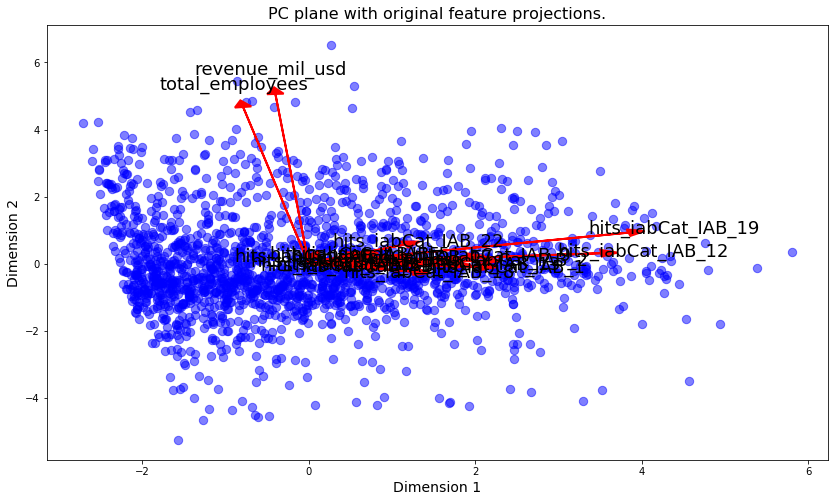

In [45]:
# Create a biplot
vs.biplot(log_data, reduced_data, pca)

## Creating Clusters k-means
Investigate if feature scaling and dimensionality reduction aids in the creation of better clusters


In [46]:
#Example https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
def applyKmeans(k,data):
    #Apply clustering algorithm to the data 
    clusterer = KMeans(n_clusters=k,random_state=1).fit(data)
    #Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    #Find the cluster centers (not applicable to DB scan)
    centers = clusterer.cluster_centers_
    #Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print("K="+str(k) + ", Silhouette Score - "+ str(score))

In [47]:
#Investigate what is the optimal value for k
clustersN=[2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]
for i in clustersN:
    applyKmeans(i,reduced_data)

K=2, Silhouette Score - 0.22262824559781863
K=3, Silhouette Score - 0.197938280607287
K=4, Silhouette Score - 0.14799597281540847
K=5, Silhouette Score - 0.14922108533016637
K=10, Silhouette Score - 0.10770142595265121
K=15, Silhouette Score - 0.1116385710386286
K=20, Silhouette Score - 0.10955929404079649
K=25, Silhouette Score - 0.10501640204102061
K=30, Silhouette Score - 0.10069649409900068
K=35, Silhouette Score - 0.10730642035369138
K=40, Silhouette Score - 0.09667682311234543
K=45, Silhouette Score - 0.10003631748542147
K=50, Silhouette Score - 0.10557446892408442
K=60, Silhouette Score - 0.09700226089632806
K=70, Silhouette Score - 0.10464939069185518
K=80, Silhouette Score - 0.09881345174377527
K=90, Silhouette Score - 0.10251709274797294
K=100, Silhouette Score - 0.10509426293548445


### Cluster Visualization for optimal k-means


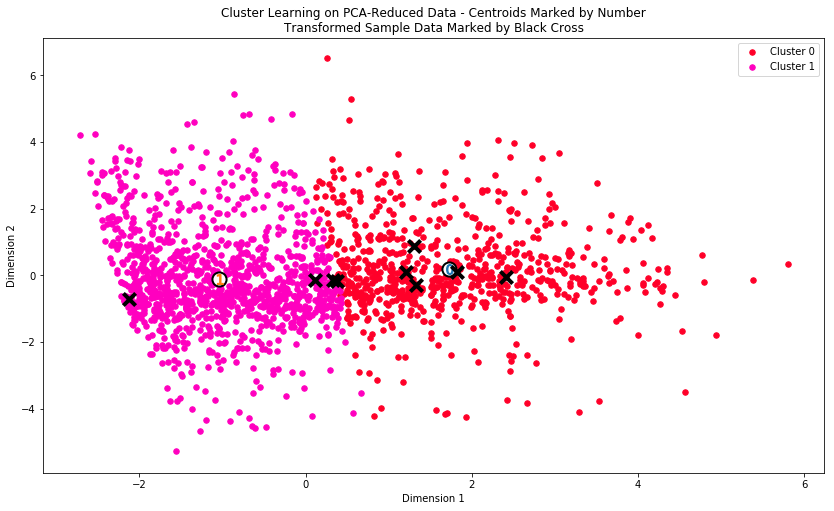

In [48]:
k=2
#Apply clustering algorithm to the data 
clusterer = KMeans(n_clusters=k,random_state=1).fit(reduced_data)
#Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
#Find the cluster centers (not applicable to DB scan)
centers = clusterer.cluster_centers_
#Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery
Applying the inverse operations to the data following transformations


In [49]:
#Inverse transform the centers
log_centers = pca.inverse_transform(centers)

#Exponentiate the centers and remove the 1 from earlier (used to prevent log 0 error)
true_centers = np.exp(log_centers) - 1

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = good_data.keys())
true_centers.index = segments
display(true_centers)
true_centers.to_csv('summary_clusters.csv')

hits_iabCat_IAB_1  hits_iabCat_IAB_10  hits_iabCat_IAB_12  \
Segment 0                2.0                 0.0                 7.0   
Segment 1                0.0                 0.0                 1.0   

           hits_iabCat_IAB_13  hits_iabCat_IAB_15  hits_iabCat_IAB_17  \
Segment 0                 2.0                 0.0                 1.0   
Segment 1                 0.0                 0.0                 0.0   

           hits_iabCat_IAB_18  hits_iabCat_IAB_19  hits_iabCat_IAB_2  \
Segment 0                 1.0                 8.0                2.0   
Segment 1                 0.0                 1.0                0.0   

           hits_iabCat_IAB_21  hits_iabCat_IAB_22  hits_iabCat_IAB_3  \
Segment 0                 0.0                 1.0                0.0   
Segment 1                 0.0                 0.0                0.0   

           hits_iabCat_IAB_4  hits_iabCat_IAB_5  hits_iabCat_IAB_7  \
Segment 0                0.0                1.0                0.0   
Segment 1                0.0                0.0                0.0   

           hits_iabCat_IAB_9  revenue_mil_usd  total_employees  
Segment 0                2.0             14.0             86.0  
Segment 1                0.0             13.0            100.0

## Summary K-means
This is definitely an improvement on the benchmark model as we can at least see some form of clustering that might proivide useful insights to marketers.

# Clustering DB Scan
Investigate alternative clustering methods where the number of clusters is found based on distance (epsilon)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric=’euclidean’, metric_params=None, algorithm=’auto’, leaf_size=30, p=None, n_jobs=None)[source]

In [50]:
# Compute DBSCAN
def applyDBSCAN(epsilon,data):
    db = DBSCAN(eps=epsilon, min_samples=10).fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)   
    #Results
    if (n_noise_ == len(data)) or len(set(labels)) <=1:
        score=0
    else:
        score = metrics.silhouette_score(data, labels)
    print("Epsilon= " + str(epsilon)+ ". Silhouette Score= "+str(score) + ". Clusters= "+str(n_clusters_)+" with an estimated number of noise points = "+ str(n_noise_))

In [51]:
epsilons=[0.0001, 0.001,0.01,1,2,3,4,5,6,7,8,9,10,20,30,40,50]
for i in epsilons:
    applyDBSCAN(i,reduced_data)

Epsilon= 0.0001. Silhouette Score= 0. Clusters= 0 with an estimated number of noise points = 1899
Epsilon= 0.001. Silhouette Score= 0. Clusters= 0 with an estimated number of noise points = 1899
Epsilon= 0.01. Silhouette Score= 0. Clusters= 0 with an estimated number of noise points = 1899
Epsilon= 1. Silhouette Score= 0.05563577684907343. Clusters= 1 with an estimated number of noise points = 1422
Epsilon= 2. Silhouette Score= 0.2571510599297678. Clusters= 1 with an estimated number of noise points = 186
Epsilon= 3. Silhouette Score= 0.40364274097546005. Clusters= 1 with an estimated number of noise points = 8
Epsilon= 4. Silhouette Score= 0. Clusters= 1 with an estimated number of noise points = 0
Epsilon= 5. Silhouette Score= 0. Clusters= 1 with an estimated number of noise points = 0
Epsilon= 6. Silhouette Score= 0. Clusters= 1 with an estimated number of noise points = 0
Epsilon= 7. Silhouette Score= 0. Clusters= 1 with an estimated number of noise points = 0
Epsilon= 8. Silhouett

# Summary K-means
Only a single cluster can be derived at best. This further validates the idea that there are not truly and distinct cluster present in the dataset

# Summary & Conclusions
Using k-means to try and determine if there are distinct cluster of companies to be found within this dataset, based on their web activty on website of different categorisations, as per the IAB taxonomy, there appears to be no distinct behaviour of companies. A sillouhette score of 0.19 highlights this along with the clustering visualisation above which clusters with large overlaps.

Next Steps for the Business:
- There are clearly some serious data quality issue here. The business needs to decide if it is worth investing in monitioring any of the blacklisted categories or a decision should be made to stop tracking activity on blacklisted IAB categorised website 

- Click data needs to be increased in order to drive any significant machine learning inferences going forward. Right now we not have significant data accross all accounts. I'd suggest we invest in serving display ads to all companies in our database to be building up a baseline for activity and help drive future analysis.

- There are some serious outliers, which should be taken into consideration with the existing scoring models, as they could skew the entire accounts list. Highly likely they will always bubble to the top of client accounts

Further Analysis:
- Can any inferences be made at a high level of granulairty other than company, e.g. at the country level?
- Hierachal clustering methods to determine the number of clusters